<a href="https://colab.research.google.com/github/ialara/actf/blob/e2e-prototype/absorption_e2e_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from collections import Counter
rng = np.random.default_rng()

class Pilot:
    ftu_sorties = 59
    def __init__(self, i, f16_sorties=59, tos=0, experienced=False):
        self.id = i
        self.f16_sorties = f16_sorties
        self.tos = tos
        self.experienced = experienced
        self.arrived_month = 0
        self.in_ug = False
        self.ug = None
        self.ride_num = None
        self.quals = []
        self.tte = 0

    def set_arrived_month(self, month):
        self.arrived_month = month

    def increment_tos(self, months=1):
        self.tos += months

    def increment_f16_sorties(self, sortie_increment=1):
        self.f16_sorties += sortie_increment
        if self.in_ug:
          self.ride_num += sortie_increment

    def enroll_in_ug(self, ug, start_month=0):
        if self.in_ug:
            #print(f'PID {self.id} already enrolled in {self.ug}. {f"Did not enroll in {ug}." if self.ug != ug else ""}')
            return
        self.in_ug = True
        self.ug = ug
        self.ug_start_month = start_month
        self.ride_num = 0
        #print(f'PID {self.id} enrolled in {self.ug}.')
      
    def disenroll_from_ug(self):
        self.in_ug = False
        self.ug = None
        self.ride_num = None

    def award_qual(self, qual):
        if qual not in self.quals:
            self.quals.append(qual)

    def print_(self):
        msg = [f'ID: {self.id:2d} | EXP: {"Y" if self.experienced else "N"} | ',
               f'TOS: {self.tos:2d} | STY: {self.f16_sorties:3d} | ARR: {self.arrived_month:2d} | ',
               f'TTE: {self.tte if self.experienced else "- ":2} | QUAL: {self.quals}']
        if self.ug is not None:
            msg.append(f' | UG: {self.ug} #{self.ride_num}')

        print(*msg)

class Squadron:
    def __init__(self, name='default_Squadron', syllabi=None):
        self.name = name
        self.pilots = []
        self.pid = 0
        if syllabi is None:
            self.syllabi = {}

    def assign_pilot(self, pilot, arrived_month=0):
        self.pilots.append(pilot)
        pilot.set_arrived_month(arrived_month)

    def add_syllabi(self, syllabi):
        self.syllabi = syllabi

    def set_syllabus_ug_capacity(self, syllabus, capacity):
        syllabus.capacity = capacity

    def set_monthly_sorties_available(self, capacity=240):
        self.monthly_sorties_available = capacity

    def _next_pid(self):
        self.pid += 1
        return self.pid

    def get_pilot_by_id(self, id):
        pilot_dict = {p.id: p for p in self.pilots}
        return pilot_dict[id]

    def get_pilots_by_qual(self):
        quals = np.asarray(self._get_highest_quals())
        pilots = np.asarray(self.pilots)

        return {q: list(pilots[quals == q]) for q in Counter(quals).keys()}


    def populate_initial(self, num_pilots=20, prop_EXP=0.8, prop_IP=0.4):
        num_EXP = rng.binomial(num_pilots, prop_EXP)
        num_IP = rng.binomial(num_EXP, prop_IP)
        num_INX = num_pilots - num_EXP

        # Parameters
        min_TOS_INX = 0
        max_TOS_INX = 24
        min_TOS_EXP = 16
        max_TOS_EXP = 32

        min_sorties_INX = Pilot.ftu_sorties
        max_sorties_INX = Syllabus.exp_sortie_rqmt
        min_sorties_EXP = Syllabus.exp_sortie_rqmt
        max_sorties_EXP = 2*Syllabus.exp_sortie_rqmt

        # Assign INX pilots
        for _ in range(num_INX):
            my_tos = rng.integers(min_TOS_INX, max_TOS_INX)
            my_sorties = rng.integers(min_sorties_INX, max_sorties_INX)
            my_sorties = min(my_sorties, min_sorties_INX + (my_tos+1)*5)
            inx_pilot = Pilot(self._next_pid(), f16_sorties=my_sorties, tos=my_tos)

            inx_pilot.inflow_source = 'initial'
            if inx_pilot.tos > 2: # Assume initial population completes MQT in specified timeline
                inx_pilot.increment_f16_sorties(9) # Duration of MQT
                inx_pilot.award_qual('WG')
                inx_pilot.inflow_source += ' WG'
            else:
                my_ug_prog = rng.integers(9) # MQT and FLUG have same duration
                if inx_pilot.f16_sorties < 75:
                    inx_pilot.enroll_in_ug('MQT')
                    #self.syllabi['MQT'].capacity -= 1
                    inx_pilot.increment_f16_sorties(my_ug_prog)
                elif inx_pilot.f16_sorties < 200:
                    inx_pilot.award_qual('WG')
                    inx_pilot.inflow_source += ' WG'
                    if rng.random() < 0.7:
                        inx_pilot.enroll_in_ug('FLUG')
                        #self.syllabi['FLUG'].capacity -= 1
                        inx_pilot.increment_f16_sorties(my_ug_prog)
                        inx_pilot.inflow_source += '/FLUG'

                else:
                    inx_pilot.award_qual('WG')
                    if rng.random() < 0.7:
                        inx_pilot.award_qual('FL')
                        inx_pilot.inflow_source += ' FL'
            self.assign_pilot(inx_pilot)
          
        # Assign EXP pilots
        ips_remaining = num_IP
        for _ in range(num_EXP):
            my_tos = rng.integers(min_TOS_EXP, max_TOS_EXP)
            my_sorties = rng.integers(min_sorties_EXP, max_sorties_EXP)
            exp_pilot = Pilot(self._next_pid(), f16_sorties=my_sorties, tos=my_tos,
                              experienced = True)
            exp_pilot.award_qual(Syllabus.exp_qual_rqmt)
            if ips_remaining > 0:
                exp_pilot.award_qual('IP')
                ips_remaining -= 1
            elif rng.random() < 0.2:
              exp_pilot.enroll_in_ug('IPUG')
              #self.syllabi['IPUG'].capacity -= 1
              exp_pilot.increment_f16_sorties(rng.integers(9))

            self.assign_pilot(exp_pilot)

    def inflow_from_ftu(self, num_pilots=15, arrival_month=0):
        for _ in range(num_pilots):
            ftu_sortie_delta = rng.integers(-5, 5)
            my_f16_sorties = Pilot.ftu_sorties + ftu_sortie_delta
            new_pilot = Pilot(self._next_pid(), f16_sorties = my_f16_sorties)
            new_pilot.set_arrived_month(arrival_month)
            new_pilot.inflow_source = 'FTU'
            self.assign_pilot(new_pilot)

    def inflow_nth_tour(self, num_pilots=20, prop_IP=0.4, prop_WG=0.1, arrival_month=0):
        num_IP = rng.binomial(num_pilots, prop_IP)
        num_WG = rng.binomial(num_pilots, prop_WG)
        num_FL = num_pilots - num_IP - num_WG

        # Parameters
        min_sorties_WG = int(0.7*Syllabus.exp_sortie_rqmt)
        max_sorties_WG = int(0.9*Syllabus.exp_sortie_rqmt)
        min_sorties_FL = int(0.9*Syllabus.exp_sortie_rqmt)
        max_sorties_FL = int(2*Syllabus.exp_sortie_rqmt)
        min_sorties_IP = int(1.5*Syllabus.exp_sortie_rqmt)
        max_sorties_IP = 4*Syllabus.exp_sortie_rqmt

        for _ in range(num_IP):
            my_sorties = rng.integers(min_sorties_IP, max_sorties_IP)
            new_IP = Pilot(self._next_pid(), f16_sorties = my_sorties, experienced=True)
            new_IP.award_qual('IP')
            self.assign_pilot(new_IP, arrived_month=arrival_month)

        for _ in range(num_FL):
            my_sorties = rng.integers(min_sorties_FL, max_sorties_FL)
            new_FL = Pilot(self._next_pid(), f16_sorties = my_sorties)
            new_FL.award_qual('FL')
            new_FL.experienced = Syllabus.meets_EXP_criteria(new_FL.f16_sorties, new_FL.quals)
            new_FL.inflow_source = 'nth tour'
            self.assign_pilot(new_FL, arrived_month=arrival_month)

        for _ in range(num_WG):
            my_sorties = rng.integers(min_sorties_WG, max_sorties_WG)
            new_WG = Pilot(self._next_pid(), f16_sorties = my_sorties)
            new_WG.award_qual('WG')
            new_WG.inflow_source = 'nth tour'
            self.assign_pilot(new_WG, arrived_month=arrival_month)
            
    def inflow_pilots(self, num_ftu=15, num_nth_tour=5, arrival_month=0):
        self.inflow_from_ftu(num_ftu, arrival_month=arrival_month)
        self.inflow_nth_tour(num_nth_tour, arrival_month=arrival_month)

    def outflow_pilots(self, tos_threshold=32):
        removed_pilots = [p for p in self.pilots if p.tos >= tos_threshold]
        self.pilots = [p for p in self.pilots if p not in set(removed_pilots)]
        return removed_pilots

    def enroll_ug_students(self, start_month=0):
        pilots_by_quals = self.get_pilots_by_qual()

        try:
            mqt_candidates = pilots_by_quals['']
        except KeyError:
            mqt_candidates = []
        try:
            flug_candidates = pilots_by_quals['WG']
        except KeyError:
            flug_candidates = []
        try:
            ipug_candidates = pilots_by_quals['FL']
            ipug_candidates = [p for p in ipug_candidates if p.experienced]
        except KeyError:
            ipug_candidates = []
            
        # Prioritize students (e.g. by TOS for MQT; sorties for FLUG/IPUG)
        mqt_candidates.sort(key=lambda x: (x.tos, x.f16_sorties), reverse=True)
        flug_candidates.sort(key=lambda x: x.f16_sorties, reverse=True)
        ipug_candidates.sort(key=lambda x: x.f16_sorties, reverse=True)
        # Enroll as many as possible, subject to capacity of upgrade program
        for students, program in zip([mqt_candidates, flug_candidates, ipug_candidates],
                                     self.syllabi.values()):
          # TODO: Note this is not guaranteed if programs have different capacities
          # (self.syllabi.values() order returned is random)
            enrollees = students[:program.capacity]
            for e in enrollees:
              e.enroll_in_ug(program.name, start_month=start_month)

    def fly_month(self, sorties_available=None, INX_sortie_pct=0.4):
        if sorties_available is None:
            sorties_available = self.monthly_sorties_available
        INX_sorties = int(sorties_available * INX_sortie_pct)
        INX_pilots = [p for p in self.pilots if not p.experienced]
        num_INX_pilots = len(INX_pilots)

        for p in self.pilots:
            p.scm = 0

        rng.shuffle(INX_pilots)
        INX_sorties_remaining = INX_sorties
        sorties_remaining = sorties_available
        for p in INX_pilots:
          # TODO: Confirm statistical correctness (probability and use of binomial)
            my_draw = rng.binomial(INX_sorties, 1 / num_INX_pilots)
            my_SCM = max(min(my_draw, INX_sorties_remaining, sorties_available), 0)
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}.')
            p.scm = my_SCM
            p.increment_f16_sorties(p.scm)
            # Increment for IPs/FLs
            try:
              if p.in_ug:
                  support_flown = rng.choice(self.get_pilots_by_qual()['IP'], size=p.scm)
              else:
                  try:
                      support_pool = self.get_pilots_by_qual()['FL']
                  except KeyError:
                      support_pool = self.get_pilots_by_qual()['IP']
                  support_flown = rng.choice(support_pool, size=p.scm)
            except KeyError:
              support_flown = []
            for support_pilot in support_flown:
                support_pilot.increment_f16_sorties()
                support_pilot.scm += 1
                sorties_remaining -= 1           
            INX_sorties_remaining -= p.scm
            sorties_remaining -= p.scm

        EXP_pilots = [p for p in self.pilots if p.experienced]
        EXP_sorties = max(sorties_remaining, 0)
        for p in EXP_pilots:
            my_draw = rng.binomial(EXP_sorties, 1 / len(EXP_pilots))
            my_SCM = max(min(my_draw, sorties_remaining), 0)
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}.')
            p.scm += my_SCM
            p.increment_f16_sorties(my_SCM)
            sorties_remaining -= my_SCM

            

        print(f'EOM INX sorties remaining: {INX_sorties_remaining}')
        print(f'EOM total sorties remaining: {sorties_remaining}')
        scms_inx = np.asarray([p.scm for p in self.pilots if not p.experienced])
        scms_exp = np.asarray([p.scm for p in self.pilots if p.experienced])
        print('EOM SCM summary:')
        print(f'--INX: min {min(scms_inx)} / mean {np.mean(scms_inx):.1f} / max {max(scms_inx)} / mode {Counter(scms_inx).most_common(1)}')
        print(f'--EXP: min {min(scms_exp)} / mean {np.mean(scms_exp):.1f} / max {max(scms_exp)} / mode {Counter(scms_exp).most_common(1)}')
        print()
        print('Monthly flight activity:')

        return {'INX': scms_inx, 'EXP': scms_exp}

    def update_qualifications(self, sim_month, ugs):
        ttes = []
        for p in self.pilots:
            was_experienced = p.experienced
            p.experienced = Syllabus.meets_EXP_criteria(p.f16_sorties, p.quals)
            if p.experienced and not was_experienced: # "became" EXP
                # Calculate TTE
                p.tte = sim_month - p.arrived_month
                print(f'!! PID {p.id:3d} experienced. TTE: {p.tte:2d} months. Inflow source? {p.inflow_source}')
                ttes.append({'PID': p.id, 'Source': p.inflow_source, 'TTE': p.tte})

            if p.in_ug and p.ride_num >= ugs[p.ug].duration:
                # Upgrade complete, award qualification
                print(f'PID {p.id:3d} completed {p.ug:4s} in {sim_month - p.ug_start_month:2d} months. Awarded {ugs[p.ug].award}.')
                p.award_qual(ugs[p.ug].award)
                #self.syllabi[p.ug].capacity += 1
                p.disenroll_from_ug()
        return ttes     

    def age_squadron(self, months=1):
        for p in self.pilots:
            p.increment_tos(months)

    def summarize(self):
        quals = Counter(self._get_highest_quals())
        ugs = Counter(self._get_ug_enrollment())
        exp = Counter(self._get_experience())

        exp_str = [f'{"EXP" if q else "INX":6s} -> {num:3d} | ' for q, num in exp.items()]
        print('EXPR:', *exp_str, f'PILOTS -> {exp[True] + exp[False]:3d} | {exp[True]/(exp[True]+exp[False])*100:.0f}% EXP')
        quals_str = [f'{q if q is not "" else "(none)":6s} -> {num:3d} | ' for q, num in quals.items()]
        print('QUAL:', *quals_str)
        ugs_str = [f'{q if q is not None else "(none)":6s} -> {num:3d} | ' for q, num in ugs.items()]
        print('UPGS:', *ugs_str)

        return {'EXPR': exp,
                'QUAL': quals,
                'UPGS': ugs}

    def _get_highest_quals(self, pilots=None):
        if pilots is None:
            pilots = self.pilots
        return [p.quals[-1] if len(p.quals) > 0 else '' for p in pilots]

    def _get_ug_enrollment(self):
        return [p.ug for p in self.pilots]

    def _get_experience(self):
        return [p.experienced for p in self.pilots]

    def print_(self):
        for p in self.pilots:
            p.print_()

class Simulation:
    def __init__(self, run_num=0):
        self.run_num = run_num
        self.month_num = 0

    def setup(self, initial_size=20, monthly_sortie_capacity=240):
        self.sq = Squadron('test_Squadron')
        self.syllabi = {s.name: s for s in [Syllabus('MQT', 9, 'WG'),
                                            Syllabus('FLUG', 9, 'FL'),
                                            Syllabus('IPUG', 9, 'IP')]}
        for syll in self.syllabi.values():
            syll.capacity = 6
        self.sq.add_syllabi(self.syllabi)
        self.sq.populate_initial(initial_size)
        self.sq.set_monthly_sorties_available(monthly_sortie_capacity)

        # Stat tracking
        self.monthly_stats = {'SCM_INX': [],
                              'SCM_EXP': [],
                              'NUM_IN_UGS': [],
                              'NUM_BY_EXP': [],
                              'NUM_BY_QUAL': []}
        self.per_pilot_stats = {'TTE': [],
                                'NUM_DEPARTED_INX': 0}

    def step_month(self, num_months=1, inflow_ftu=15, inflow_nth=5, tos_threshold=32):
        for _ in range(num_months):
            self.month_num += 1
            print(f'---SIM MONTH {self.month_num}---')
            self.sq.inflow_pilots(inflow_ftu, inflow_nth, self.month_num)
            print('>>>After inflow/enrollment:')
            #self.sq.print_()
            self.sq.enroll_ug_students(start_month=self.month_num)
            # TODO: Tidy into a function
            summary = self.sq.summarize()
            self.monthly_stats['NUM_IN_UGS'].append(summary['UPGS'])
            self.monthly_stats['NUM_BY_QUAL'].append(summary['QUAL'])
            self.monthly_stats['NUM_BY_EXP'].append(summary['EXPR'])            
            print()
            scms = self.sq.fly_month()
            self.monthly_stats['SCM_INX'].append(scms['INX'])
            self.monthly_stats['SCM_EXP'].append(scms['EXP'])
            #print('>>>After flying:')
            #self.sq.summarize()
            # for p in self.sq.pilots:
            #   print(f'PID {p.id} flew {p.scm} sorties.')
            self.sq.age_squadron()
            # print('After aging:')
            # self.sq.summarize()
            ttes = self.sq.update_qualifications(self.month_num, self.syllabi)
            if len(ttes) > 0:
                for tte in ttes:
                    self.per_pilot_stats['TTE'].append(tte)
            removed_pilots = self.sq.outflow_pilots(tos_threshold)
            self.per_pilot_stats['NUM_DEPARTED_INX'] += sum([not p.experienced for p in removed_pilots])
            print()
            print(f'Pilots departed: {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(removed_pilots)).items()]}')
            print('>>>After outflow:')
            self.sq.summarize()
            print()

class Syllabus:
    exp_sortie_rqmt = 250
    exp_qual_rqmt = 'FL'
    def __init__(self, name, duration, award):
        self.name = name
        self.duration = duration
        self.award = award   
    @staticmethod
    def meets_EXP_criteria(pilot_sorties, pilot_qualifications):
        return (pilot_sorties >= Syllabus.exp_sortie_rqmt and 
               Syllabus.exp_qual_rqmt in pilot_qualifications)

In [3]:
sq = Squadron('test_Sq')
sq.populate_initial(30)
sq.summarize()

EXPR: INX    ->   6 |  EXP    ->  24 |  PILOTS ->  30 | 80% EXP
QUAL: WG     ->   5 |  (none) ->   1 |  IP     ->   6 |  FL     ->  18 | 
UPGS: (none) ->  22 |  MQT    ->   1 |  IPUG   ->   7 | 


{'EXPR': Counter({False: 6, True: 24}),
 'QUAL': Counter({'WG': 5, '': 1, 'IP': 6, 'FL': 18}),
 'UPGS': Counter({None: 22, 'MQT': 1, 'IPUG': 7})}

In [ ]:
sq.print_()

ID:  1 | EXP: N |  TOS: 19 | STY: 163 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  2 | EXP: N |  TOS: 20 | STY: 173 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  3 | EXP: N |  TOS:  3 | STY:  88 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  4 | EXP: N |  TOS: 21 | STY: 178 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  5 | EXP: N |  TOS:  2 | STY:  80 | ARR:  0 |  TTE: -  | QUAL: []  | UG: MQT #6
ID:  6 | EXP: N |  TOS:  5 | STY:  98 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  7 | EXP: N |  TOS: 20 | STY: 167 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  8 | EXP: N |  TOS: 14 | STY: 143 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID:  9 | EXP: N |  TOS: 19 | STY:  86 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID: 10 | EXP: N |  TOS:  3 | STY:  88 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID: 11 | EXP: N |  TOS: 19 | STY:  80 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID: 12 | EXP: N |  TOS:  7 | STY: 108 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID: 13 | EXP: N |  TOS: 17 | STY: 158 | ARR:  0 |  TTE: -  | QUAL: ['WG']
ID: 14 | EXP: N |  TOS: 12 |

In [26]:
sim = Simulation()
sim.setup()
sim.sq.summarize()

EXPR: INX    ->   6 |  EXP    ->  14 |  PILOTS ->  20 | 70% EXP
QUAL: WG     ->   5 |  (none) ->   1 |  IP     ->   6 |  FL     ->   8 | 
UPGS: (none) ->  17 |  MQT    ->   1 |  IPUG   ->   2 | 


{'EXPR': Counter({False: 6, True: 14}),
 'QUAL': Counter({'WG': 5, '': 1, 'IP': 6, 'FL': 8}),
 'UPGS': Counter({None: 17, 'MQT': 1, 'IPUG': 2})}

In [27]:
NUM_YEARS = 5
ftu_arrivals = [6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0]*NUM_YEARS
nth_arrivals = [4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]*NUM_YEARS
for ftu, nth in zip(ftu_arrivals, nth_arrivals):
    sim.step_month(inflow_ftu=ftu, inflow_nth=nth)
#im.monthly_stats

---SIM MONTH 1---
>>>After inflow/enrollment:
EXPR: INX    ->  13 |  EXP    ->  17 |  PILOTS ->  30 | 57% EXP
QUAL: WG     ->   6 |  (none) ->   7 |  IP     ->   8 |  FL     ->   9 | 
UPGS: FLUG   ->   6 |  MQT    ->   6 |  (none) ->  12 |  IPUG   ->   6 | 

EOM INX sorties remaining: 5
EOM total sorties remaining: 0
EOM SCM summary:
--INX: min 4 / mean 7.0 / max 10 / mode [(7, 4)]
--EXP: min 2 / mean 8.8 / max 19 / mode [(2, 3)]

Monthly flight activity:
PID   3 completed MQT  in  1 months. Awarded WG.
PID   5 completed FLUG in  0 months. Awarded FL.
PID  14 completed IPUG in  1 months. Awarded IP.

Pilots departed: []
>>>After outflow:
EXPR: INX    ->  15 |  EXP    ->  15 |  PILOTS ->  30 | 50% EXP
QUAL: WG     ->   6 |  FL     ->   9 |  IP     ->   9 |  (none) ->   6 | 
UPGS: FLUG   ->   5 |  (none) ->  15 |  IPUG   ->   5 |  MQT    ->   5 | 

---SIM MONTH 2---
>>>After inflow/enrollment:
EXPR: INX    ->  15 |  EXP    ->  15 |  PILOTS ->  30 | 50% EXP
QUAL: WG     ->   6 |  FL     -

In [28]:
per_pilot = sim.per_pilot_stats
per_pilot

{'TTE': [{'PID': 30, 'Source': 'nth tour', 'TTE': 5},
  {'PID': 2, 'Source': 'initial WG', 'TTE': 9},
  {'PID': 1, 'Source': 'initial WG', 'TTE': 10},
  {'PID': 5, 'Source': 'initial WG', 'TTE': 10},
  {'PID': 6, 'Source': 'initial WG', 'TTE': 10},
  {'PID': 4, 'Source': 'initial WG', 'TTE': 15},
  {'PID': 3, 'Source': 'initial', 'TTE': 18},
  {'PID': 26, 'Source': 'FTU', 'TTE': 20},
  {'PID': 22, 'Source': 'FTU', 'TTE': 22},
  {'PID': 24, 'Source': 'FTU', 'TTE': 22},
  {'PID': 21, 'Source': 'FTU', 'TTE': 23},
  {'PID': 23, 'Source': 'FTU', 'TTE': 23},
  {'PID': 25, 'Source': 'FTU', 'TTE': 23},
  {'PID': 32, 'Source': 'FTU', 'TTE': 29},
  {'PID': 31, 'Source': 'FTU', 'TTE': 33},
  {'PID': 33, 'Source': 'FTU', 'TTE': 34},
  {'PID': 34, 'Source': 'FTU', 'TTE': 35},
  {'PID': 40, 'Source': 'FTU', 'TTE': 36},
  {'PID': 39, 'Source': 'FTU', 'TTE': 37},
  {'PID': 41, 'Source': 'FTU', 'TTE': 41},
  {'PID': 38, 'Source': 'FTU', 'TTE': 42},
  {'PID': 37, 'Source': 'FTU', 'TTE': 43},
  {'PID': 4

In [29]:
sim.sq.get_pilot_by_id(54)

KeyError: ignored

In [30]:
monthly = sim.monthly_stats
monthly.keys()

dict_keys(['SCM_INX', 'SCM_EXP', 'NUM_IN_UGS', 'NUM_BY_EXP', 'NUM_BY_QUAL'])

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import pandas as pd

In [31]:
scm_inx = monthly['SCM_INX']
scm_exp = monthly['SCM_EXP']

len(scm_inx + scm_exp)

120

In [32]:
df = pd.DataFrame(scm_inx).T.melt(var_name='month', value_name='SCM')
df['experience'] = 'INX'
df = pd.concat([df, pd.DataFrame(scm_exp).T.melt(var_name='month', value_name='SCM')]).fillna({'experience': 'EXP'}).dropna(subset=['SCM'])
df

,month,SCM,experience
0,0,7.0,INX
1,0,7.0,INX
2,0,7.0,INX
3,0,8.0,INX
4,0,10.0,INX
...,...,...,...
1009,59,7.0,EXP
1010,59,4.0,EXP
1011,59,10.0,EXP
1012,59,5.0,EXP


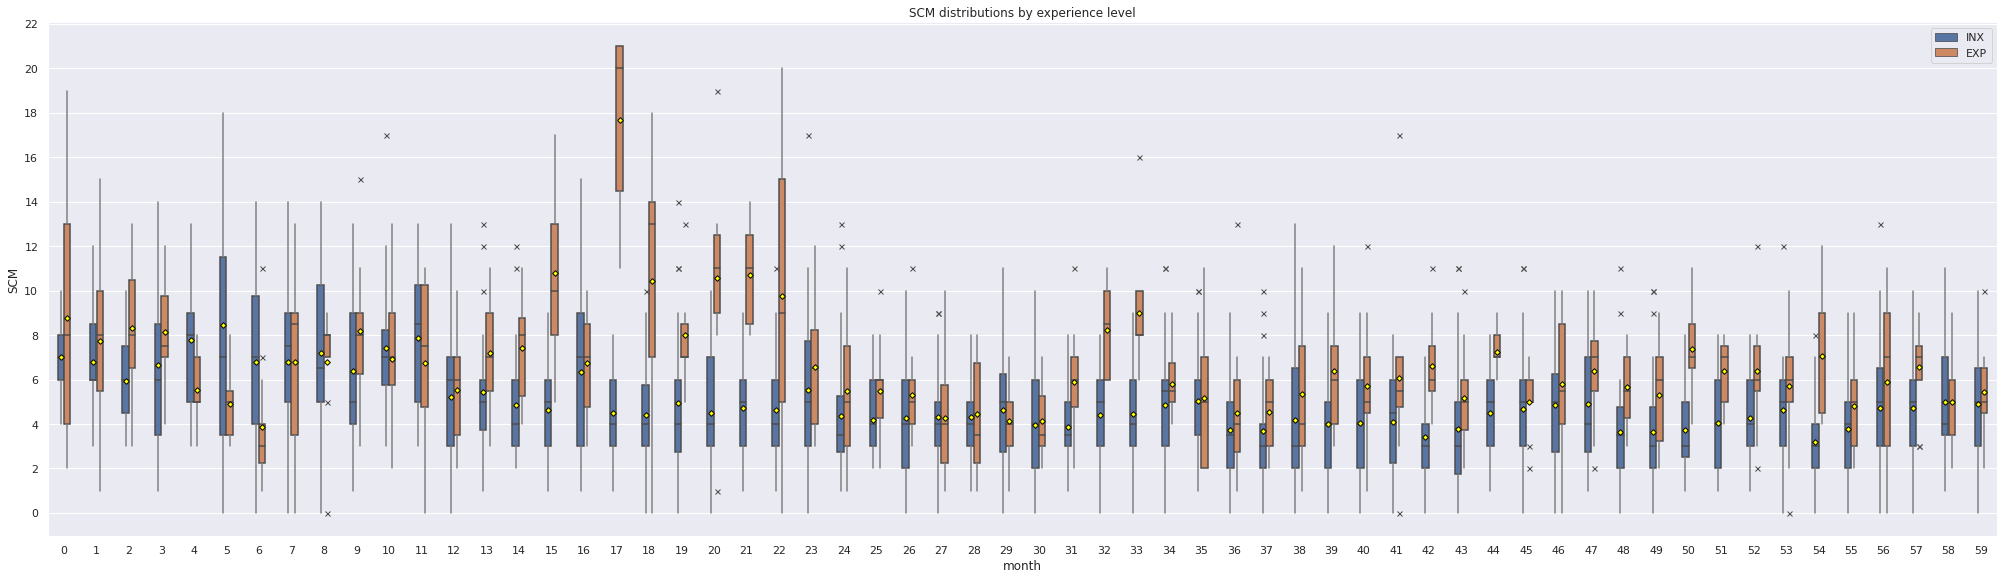

In [33]:
plt.rcParams['figure.figsize'] = (30, 12)
sns.set_theme()
box = sns.catplot(data=df, y='SCM', x='month', hue='experience', kind='box', width=0.4, showmeans=True, showcaps=False, flierprops={'marker': 'x'}, meanprops={'marker': 'D', 'markeredgecolor': 'black', 'markerfacecolor': 'yellow', 'markersize': 4}, whiskerprops={'color': 'grey'}, height=8, aspect=3.5, legend=False)
box.ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
box.ax.set_title('SCM distributions by experience level')
plt.legend()

In [34]:
foo = pd.concat([pd.DataFrame(monthly['NUM_IN_UGS']), 
           pd.DataFrame(monthly['NUM_BY_EXP']),
           pd.DataFrame(monthly['NUM_BY_QUAL'])], axis=1).rename(columns = {None: 'No upgrade',
                                                                  '': 'No qual',
                                                                  False: 'INX',
                                                                  True: 'EXP'}).fillna(0)

In [35]:
foo

,FLUG,MQT,No upgrade,IPUG,INX,EXP,WG,No qual,IP,FL
0,6.0,6.0,12,6.0,13,17,6.0,7.0,8,9
1,6.0,6.0,12,6.0,15,15,6.0,6.0,9,9
2,5.0,2.0,18,5.0,15,15,5.0,2.0,12,11
3,6.0,0.0,22,1.0,15,14,6.0,0.0,15,8
4,4.0,0.0,24,0.0,15,13,4.0,0.0,15,9
5,1.0,0.0,25,0.0,15,11,1.0,0.0,13,12
6,0.0,4.0,27,1.0,18,14,0.0,4.0,15,13
7,0.0,4.0,26,0.0,20,10,0.0,4.0,14,12
8,1.0,3.0,25,0.0,20,9,1.0,3.0,13,12
9,3.0,1.0,24,1.0,19,10,3.0,1.0,13,12


Text(0.5, 1.0, 'Unit manning by qualifications')

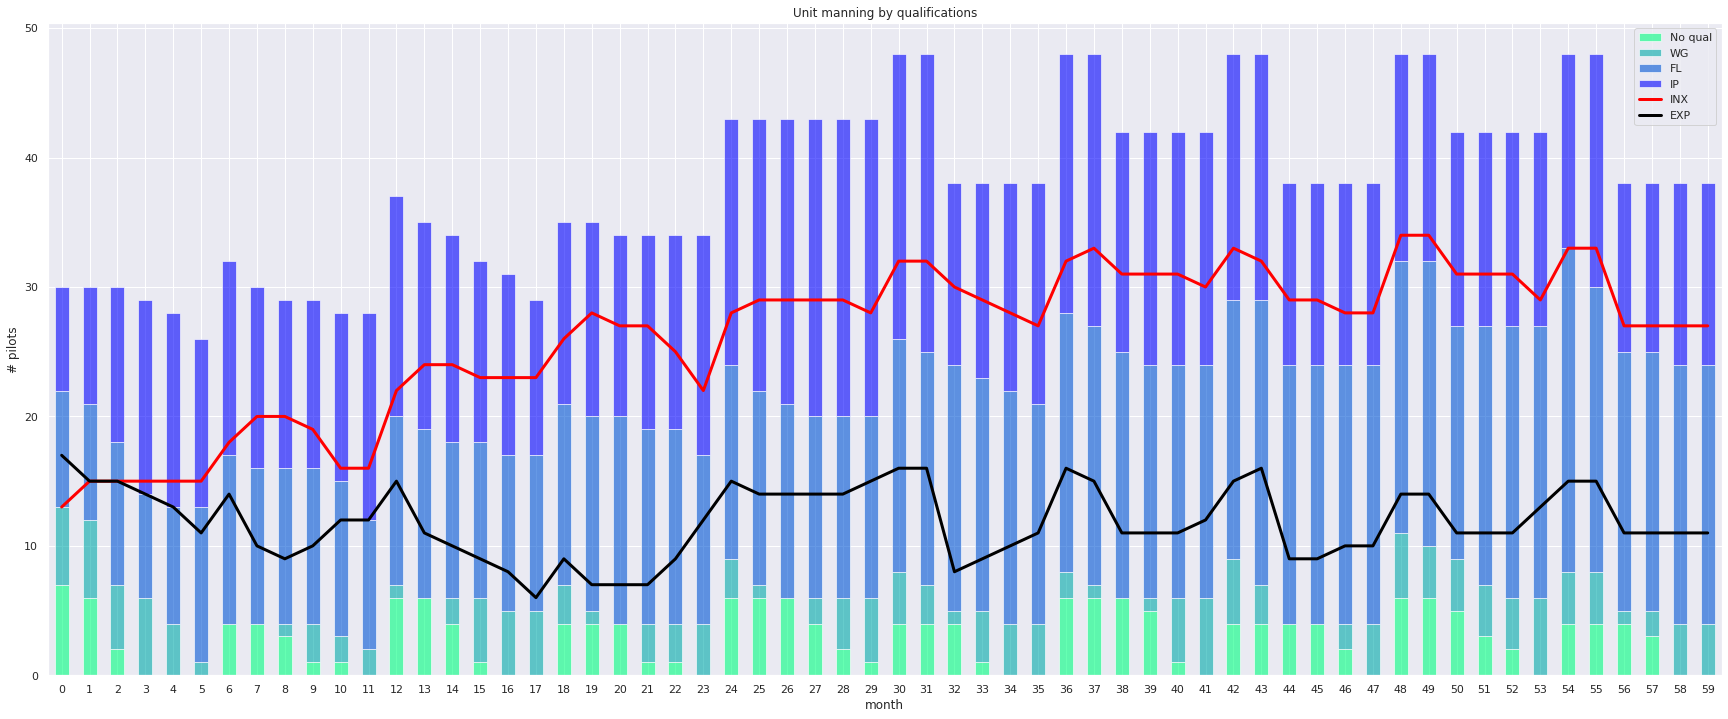

In [36]:
ax = foo[['No qual', 'WG', 'FL', 'IP']].plot(kind='bar', stacked=True, colormap='winter_r', alpha=0.6)
foo[['INX', 'EXP']].plot(kind='line', ax=ax, linewidth=3, color=['red', 'black'])
ax.set_xlabel('month')
ax.set_ylabel('# pilots')
ax.set_title('Unit manning by qualifications')